In [46]:
import yaml
import torch
from IMPA.dataset.data_loader import CellDataLoader
from IMPA.solver import IMPAmodule
import pandas as pd
from omegaconf import OmegaConf
import scanpy as sc

import numpy as np
import IMPA.featurizer.vision_transformer as vits
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

import pickle as pkl

from matplotlib import rcParams
FIGSIZE=(3,3)
rcParams['figure.figsize']=FIGSIZE

**Plotting function**

In [2]:
def pca_umap_plot_with_preprocessing(adata, title, batch_name, groups=None):
    # Set a random seed for reproducibility
    np.random.seed(0)

    # Randomly permute the indices
    random_indices = np.random.permutation(list(range(adata.shape[0])))

    if groups != None:
        # Plot the PCA with random reordering using the colorblind palette
        sc.pl.pca(adata[random_indices, :], color=batch_name, title=title, palette=sns.color_palette("colorblind"), groups=groups, s=20)
    
        # Plot the UMAP with random reordering using the colorblind palette
        sc.pl.umap(adata[random_indices, :], color=batch_name, title=title, palette=sns.color_palette("colorblind"), groups=groups, s=20)
    else:
        # Plot the PCA with random reordering using the colorblind palette
        sc.pl.pca(adata[random_indices, :], color=batch_name, title=title, palette=sns.color_palette("colorblind"), s=20)
    
        # Plot the UMAP with random reordering using the colorblind palette
        sc.pl.umap(adata[random_indices, :], color=batch_name, title=title, palette=sns.color_palette("colorblind"), s=20)

    # Show the plots
    plt.show()

def t2np(t):
    return ((t.permute(1, 2, 0) + 1) / 2).clamp(0,1).cpu().numpy()

**Code**

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

From https://github.com/broadinstitute/DINO4Cells_code

In [4]:
path_to_config = "/home/icb/alessandro.palma/environment/IMPA/IMPA/configs/config_dino.yaml"
config = yaml.safe_load(open(path_to_config, "r"))

In [5]:
config

{'model': {'model_type': 'DINO',
  'arch': 'vit_base',
  'root': '/scr/data/LINCS/DP-project/outputs/SQ00015147_maxconc/',
  'data_path': '/scr/data/LINCS/DP-project/outputs/SQ00015147_maxconc/sc-metadata.csv',
  'output_dir': '/scr/zitong/cp_dino/outputs/DINOBASE/LINCS/additional/',
  'datatype': 'CellPainting',
  'image_mode': 'normalized_4_channels',
  'channel_mode': 'drop',
  'saveckp_freq': 25,
  'batch_size_per_gpu': 300,
  'num_channels': 5,
  'patch_size': 16,
  'local_crops_scale': '0.05 0.4',
  'epochs': 300},
 'embedding': {'pretrained_weights': '/scr/zitong/cp_dino/outputs/DINOBASE01/Combined/checkpoint.pth',
  'output_path': '/scr/zitong/cp_dino/experiments/DINOBASE/LINCS/additional/features.pth',
  'df_path': '/scr/data/LINCS/DP-project/outputs/SQ00015147_maxconc/sc-metadata.csv',
  'image_size': 128,
  'num_workers': 20,
  'embedding_has_labels': False,
  'num_augmentation_repetitions': 0},
 'kaggle_test_data': {'averaged_features': True,
  'df_path': 'kaggle_test_singl

**Load model weights**

In [6]:
config["model"]["arch"] = 'vit_small'

In [7]:
model = vits.__dict__[config["model"]["arch"]](
                img_size=[128],
                patch_size=16,
                in_chans=5
            )

embed_dim = model.embed_dim

In [8]:
config["embedding"]["HEAD"] = (
        True if "HEAD" in list(config["embedding"].keys()) else False
    )

In [9]:
for p in model.parameters():
    p.requires_grad = False

In [10]:
model.eval()
model.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(5, 384, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
  (head): Identity()
)

In [11]:
pretrained_weights = "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/dino_featurization_project/Cell_Painting_data/DINO_cell_painting_small_checkpoint.pth"

In [12]:
state_dict = torch.load(pretrained_weights)

In [13]:
if "teacher" in state_dict:
    teacher = state_dict["teacher"]
    if not config["embedding"]["HEAD"] == True:
        teacher = {k.replace("module.", ""): v for k, v in teacher.items()}
        teacher = {
            k.replace("backbone.", ""): v for k, v in teacher.items()
        }
    msg = model.load_state_dict(teacher, strict=False)
else:
    student = state_dict
    if not config["embedding"]["HEAD"] == True:
        student = {k.replace("module.", ""): v for k, v in student.items()}
        student = {
            k.replace("backbone.", ""): v for k, v in student.items()
        }
    
    student = {k.replace("0.", ""): v for k, v in student.items()}
    msg = model.load_state_dict(student, strict=False)

In [14]:
model

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(5, 384, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
  (head): Identity()
)

**Featurize cells**

**Featurize RxRx1 before and after batchn transformation**

In [15]:
args = {
    "task_name": "cpg0000_batch",
    
    "img_size": 96,
    "latent_dim": 100,
    "hidden_dim": 512,
    "style_dim": 64,
    "stochastic": True,
    "z_dimension": 10,
    "dim_in": 64,
    "pert_modelling": False,
    "batch_key": "PLATE",
    "subsample_frac": 0.05,
    
    "lambda_reg": 1,
    "lambda_cyc": 1,
    "lambda_sty": 1,
    "lambda_ds": 1,
    
    "total_epochs": 20,
    "ds_iter": 100000,
    "resume_iter": 0,
    "batch_size": 32,
    "val_batch_size": 20,
    "lr": 0.0001,
    "f_lr": 0.0001,
    "beta1": 0,
    "beta2": 0.99,
    "weight_decay": 0.0001,
    "num_outs_per_domain": 10,
    "single_style": True,
    "ood_set": None,
    "mol_list": None,
    "balanced": False,
    "trainable_emb": True,
    "dataset_name": "cpg0000",
    "n_channels": 5,
    "num_workers": 8,
    "seed": 42,
    
    "image_path": "/lustre/groups/ml01/datasets/projects/cpg0000_alessandro/cpg0000_u2os_normalized_segmented_large",
    "data_index_path": "/lustre/groups/ml01/datasets/projects/cpg0000_alessandro/metadata/metadata_large.csv",
    "embedding_path": None,
    
    "experiment_directory": "../project_folder/experiments/",
    "sample_dir": "sample",
    "checkpoint_dir": "checkpoint",
    "basal_vs_real_folder": "basal_vs_real",
    "naming_key": "dataset_name",
    "embedding_folder": "embeddings",
    "resume_dir": "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments/20240101_348bb3f1-6a5b-47f2-9388-b05ba74dfcc6_cpg0000_batch/",
    
    "augment_train": True,
    "normalize": True,
    
    "print_every": 10,
    "sample_every": 1000,
    "save_every": 500,
    "eval_every": 500,
    
    "encode_rdkit": True,
    "num_layers_mapping_net": 1,
    
    "filename": "epoch_{epoch:04d}",
    "monitor": "fid_transformations",
    "mode": "min",
    "save_last": True,
    "offline": False,
    "project": "cpg0000_batch",
    "log_model": False,
    "accelerator": "gpu",
    "log_every_n_steps": 10
}
args = OmegaConf.create(args)

In [16]:
dataloader = CellDataLoader(args)

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [17]:
dest_dir = "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments/20240212_01f0ffe9-4bf5-4563-b8e4-69953cc81cf4_cpg0000_batch"

In [18]:
solver = IMPAmodule(args, dest_dir, dataloader)
solver._load_checkpoint(29)

Number of parameters in generator: 24319877
Number of parameters in style_encoder: 14330624
Number of parameters in discriminator: 14302922
Number of parameters in mapping_network: 7104
Initializing embedding_matrix...
Initializing generator...
Initializing style_encoder...
Initializing discriminator...
Initializing mapping_network...
Loading checkpoint from /home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments/20240212_01f0ffe9-4bf5-4563-b8e4-69953cc81cf4_cpg0000_batch/checkpoint/000029_nets.ckpt...
/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments/20240212_01f0ffe9-4bf5-4563-b8e4-69953cc81cf4_cpg0000_batch/checkpoint/000029_nets.ckpt
Loading checkpoint from /home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments/20240212_01f0ffe9-4bf5-4563-b8e4-69953cc81cf4_cpg0000_batch/checkpoint/000029_embeddings.ckpt...
/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments/20240212_01f0ffe9-4bf5-4563-b8e4-69

In [19]:
train_dataloader = dataloader.train_dataloader()
val_dataloader = dataloader.val_dataloader()

In [20]:
X_before_transf = []
X_after_transf = []

features = {"plate": [],
            "well": [],
            "view": [],
            "no": []}

In [21]:
# Transform all with the same random vector. Take the mean 
z_common = torch.randn(1, 100, args.z_dimension).mean(1).cuda()
with torch.no_grad():
    for loader in [train_dataloader, val_dataloader]:
        for batch in tqdm(loader):
            # # Get image 
            X = batch["X"].cuda()
            z = z_common.repeat(X.shape[0], 1)
            # Transport everything to a chosen batch, here we pick 0
            y = 0*torch.ones(X.shape[0]).long().cuda()
            y = solver.embedding_matrix(y).cuda()
            y = torch.cat([y, z], dim=1)
            y = solver.nets.mapping_network(y)
            # Transport image to new batch
            _, X_generated = solver.nets.generator(X, y)

            for i, filename in enumerate(batch["file_names"]):
                plate, well, view, no = filename.split("-")[0].split("_")
                features["plate"].append(plate)
                features["well"].append(well)
                features["view"].append(view)
                features["no"].append(no)

            Z_before_transf = model(X)
            Z_after_transf = model(X_generated)

            X_before_transf.append(Z_before_transf.detach().cpu())
            X_after_transf.append(Z_after_transf.detach().cpu())

100%|██████████| 2374/2374 [02:21<00:00, 16.75it/s]


In [22]:
X_before_transf = torch.cat(X_before_transf, dim=0)
X_after_transf = torch.cat(X_after_transf, dim=0)

In [23]:
adata_before_transf = sc.AnnData(X=X_before_transf.detach().cpu().numpy(), 
                                 obs= pd.DataFrame(features))
adata_after_transf = sc.AnnData(X=X_after_transf.detach().cpu().numpy(), 
                                 obs= pd.DataFrame(features))

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Before correction

In [24]:
groups = ['BR00116996', 'BR00116997', 'BR00116998', 'BR00116999',
       'BR00117010', 'BR00117011', 'BR00117012', 'BR00117013',
       'BR00118039', 'BR00118040']

In [25]:
sc.tl.pca(adata_before_transf)
sc.pp.neighbors(adata_before_transf)
sc.tl.umap(adata_before_transf)

In [35]:
np.unique(adata_before_transf.obs.plate)

array(['BR00116996', 'BR00116997', 'BR00116998', 'BR00116999',
       'BR00117010', 'BR00117011', 'BR00117012', 'BR00117013',
       'BR00118039', 'BR00118040'], dtype=object)

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


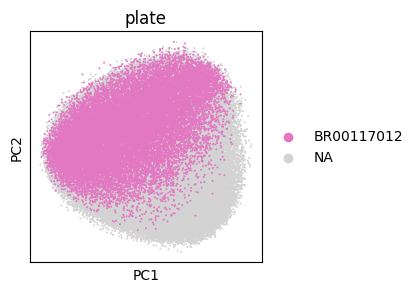

In [60]:
sc.pl.pca(adata_before_transf, color="plate", groups="BR00117012", s=8)

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


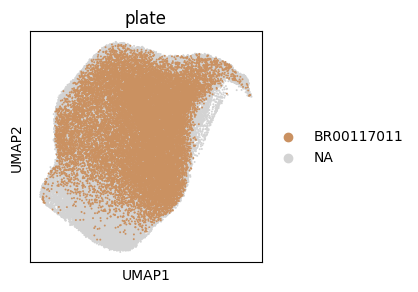

In [66]:
sc.pl.umap(adata_after_transf, color="plate", groups="BR00117011", s=8, palette=sns.color_palette("colorblind"))

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_utils.py:431: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


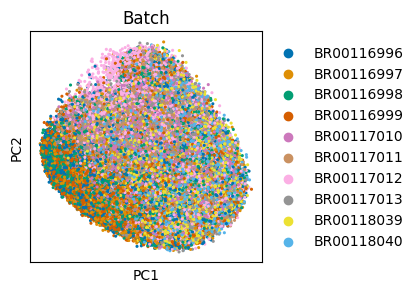

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_utils.py:431: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


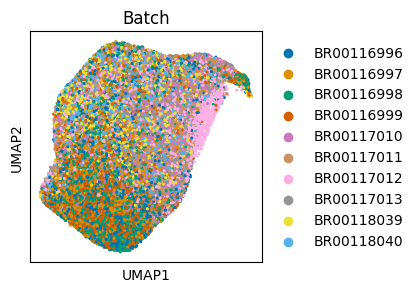

In [54]:
# for g in groups:
    # pca_umap_plot_with_preprocessing(adata_before_transf, "Batch", "plate", groups=g)
pca_umap_plot_with_preprocessing(adata_after_transf, "Batch", "plate")

After correction

In [27]:
sc.tl.pca(adata_after_transf)
sc.pp.neighbors(adata_after_transf)
sc.tl.umap(adata_after_transf)

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/

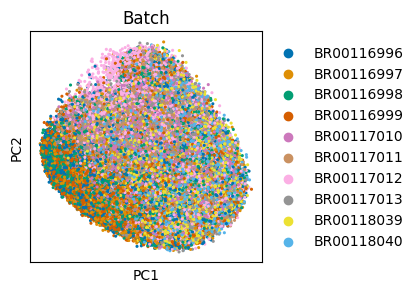

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/

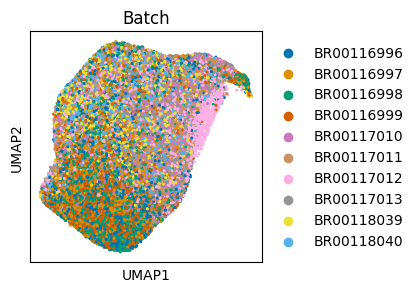

In [28]:
# for g in groups:
#     pca_umap_plot_with_preprocessing(adata_after_transf, "Batch", "plate", groups=g)
pca_umap_plot_with_preprocessing(adata_after_transf, "Batch", "plate")

In [29]:
adata_after_transf

AnnData object with n_obs × n_vars = 236340 × 384
    obs: 'plate', 'well', 'view', 'no'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

Save results

In [48]:
feature_dest_folder = Path("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/dino_featurization_project/featurized_anndata")

In [49]:
adata_before_transf.write_h5ad(feature_dest_folder / "cpg0000" / "cpg0000_adata_before_transf_2.h5ad")

In [50]:
adata_after_transf.write_h5ad(feature_dest_folder / "cpg0000" / "cpg0000_adata_after_transf_2.h5ad")

In [15]:
adata_before_transf = sc.read_h5ad(feature_dest_folder / "cpg0000"/ "cpg0000_adata_before_transf.h5ad")

In [16]:
adata_after_transf = sc.read_h5ad(feature_dest_folder / "cpg0000"/ "cpg0000_adata_after_transf.h5ad")

## Add compounds to AnnData

In [67]:
data_index = pd.read_csv('/lustre/groups/ml01/datasets/projects/cpg0000_alessandro/metadata/metadata_large.csv', index_col=1)
data_index

,Unnamed: 0,PLATE,WELL,PERT_TYPE,CPD_NAME,STATE,ANNOT,GENE,SEQUENCE,SPLIT
SAMPLE_KEY,,,,,,,,,,
BR00117010_M01_9_144,0,BR00117010,M01,Compound,DMSO,control,Compound,none,CS(=O)C,train
BR00116999_L03_6_93,1,BR00116999,L03,CRISPR,HTR2C,trt,CRISPR,HTR2C,GTTACTGCACGGCCACACCG,test
BR00116997_C07_7_109,2,BR00116997,C07,CRISPR,CYP2A6,trt,CRISPR,CYP2A6,GTTTCCAATGAAGGGCAATG,train
BR00116998_O24_1_69,3,BR00116998,O24,CRISPR,ADA,trt,CRISPR,ADA,CACAGACTGGTCCCCCAAGG,test
BR00117011_A19_8_13,4,BR00117011,A19,Compound,flupirtine,trt,Compound,KCNQ2,CCOC(=O)Nc1ccc(NCc2ccc(F)cc2)nc1N,test
...,...,...,...,...,...,...,...,...,...,...
BR00116999_I05_5_206,435156,BR00116999,I05,CRISPR,none,control,CRISPR,none,TCGATCGAGGTTGCATTCGG,train
BR00116997_F02_6_125,435157,BR00116997,F02,CRISPR,none,control,CRISPR,none,TTTACGATCTAGCGGCGTAG,train
BR00116997_M09_7_26,435158,BR00116997,M09,CRISPR,none,control,CRISPR,none,CTTACAATCGTCGGTCCAAT,train


In [18]:
# feature_df = pd.DataFrame(features)

In [12]:
compound_names = []

for row in adata_before_transf.obs.iterrows():
    plate = row[1].plate
    well = row[1].well
    view = row[1]["view"]
    no = row[1].no
    file_name = f"{plate}_{well}_{view}_{no}"
    cpd = data_index.loc[file_name].CPD_NAME
    compound_names.append(cpd)

In [13]:
adata_before_transf.obs["compound"] = compound_names

In [14]:
adata_after_transf.obs["compound"] = compound_names

## Evaluate scIB metrics

In [15]:
adata_unique = adata_before_transf.copy()

In [ ]:
adata_unique.obsm["Unintegrated"] = adata_before_transf.obsm["X_pca"]

In [ ]:
adata_unique.obsm["IMPA-Integrated"] = adata_after_transf.obsm["X_pca"]

In [46]:
from scib_metrics.benchmark import Benchmarker

In [ ]:
bm = Benchmarker(
    adata_unique,
    batch_key="plate",
    label_key="compound",
    embedding_obsm_keys=["Unintegrated", "IMPA-Integrated"],
    n_jobs=6,
)
bm.benchmark()

Metrics:   0%|          | 0/10 [00:00<?, ?it/s, Bio conservation: isolated_labels]

In [42]:
scib_path = "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/dino_featurization_project/scib/cpg0000.pkl"

In [43]:
# with open(scib_path, "wb") as file:
#     pkl.dump(bm, file)

In [44]:
with open(scib_path, "rb") as file:
    b = pkl.load(file)

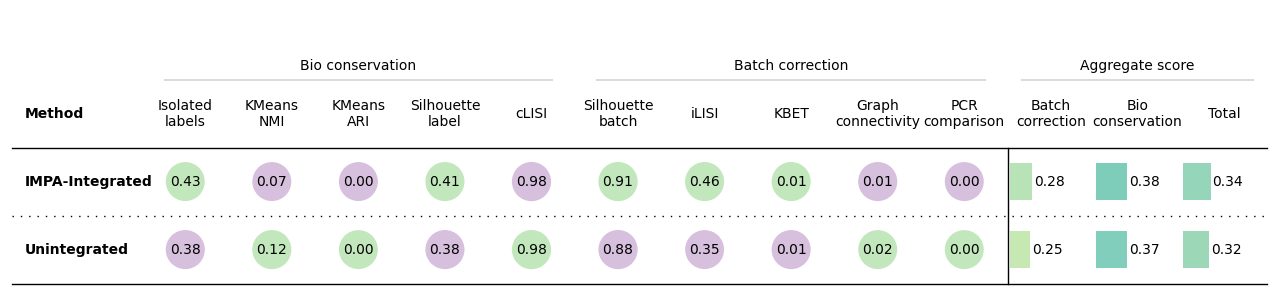

In [45]:
b.plot_results_table(min_max_scale=False)

In [47]:
df = b.get_results(min_max_scale=False)
df

,Isolated labels,KMeans NMI,KMeans ARI,Silhouette label,cLISI,Silhouette batch,iLISI,KBET,Graph connectivity,PCR comparison,Batch correction,Bio conservation,Total
Embedding,,,,,,,,,,,,,
Unintegrated,0.3831,0.123799,0.002357,0.376956,0.982691,0.881214,0.347067,0.007247,0.021759,0.000001,0.251458,0.373781,0.324851
IMPA-Integrated,0.431351,0.069865,0.000998,0.406716,0.980099,0.9122,0.460222,0.007892,0.00799,0,0.277661,0.377806,0.337748
Metric Type,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Batch correction,Batch correction,Batch correction,Batch correction,Batch correction,Aggregate score,Aggregate score,Aggregate score


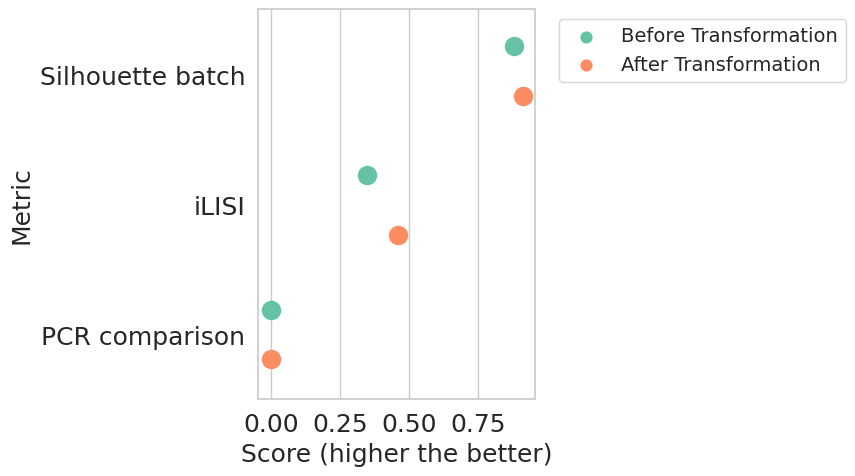

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Data from the table
# Data from the table
data = {
    'Category': ['Before Transformation', 
                 'Before Transformation', 
                 'Before Transformation', 
                 'After Transformation', 
                 'After Transformation', 
                 'After Transformation'],
    'Metric': ['Silhouette batch', 'iLISI', 'PCR comparison', 'Silhouette batch', 'iLISI', 'PCR comparison'],
    'Score': [	0.881214, 0.347067, 0, 0.9122, 0.460222, 0]
}

# Convert data to DataFrame
df = pd.DataFrame(data)

# Set aesthetic parameters
sns.set(style='whitegrid', font_scale=1.2)

# Plotting with Seaborn - Horizontal Point plot (Swarm plot)
plt.figure(figsize=(9, 5))
palette = sns.color_palette("Set2")  # Choose a suitable color palette
sns.stripplot(data=df, y='Metric', x='Score', hue='Category', palette=palette, dodge=True, jitter=True, size=14)  # Increase size here
plt.title('', fontsize=16)
plt.xlabel('Score (higher the better)', fontsize=18)
plt.ylabel('Metric', fontsize=18)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Place legend outside the plot
plt.legend(fontsize=14, bbox_to_anchor=(1.05, 1), loc='upper left')


plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


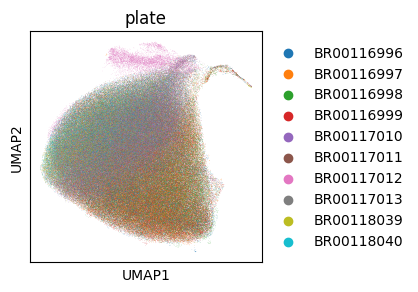

In [135]:
sc.pl.umap(ad, color="plate")

In [52]:
scgen = sc.read_h5ad("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/dino_featurization_project/featurized_anndata/cpg0000/cpg0000_adata_scgen.h5ad")

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


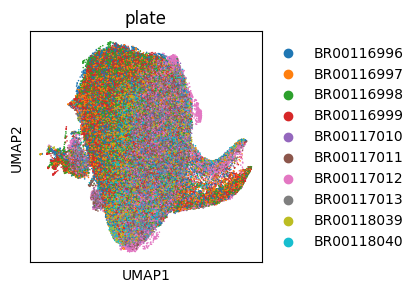

In [55]:
)